# MovingBox Intermediate Frame Prediction by LSTM | Train

In [1]:
from util import *
from util.parser import *
from util.saver import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from IPython import display
import numpy as np
from util.tf_ops import *
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image
from time import time
import tensorflow.contrib.rnn as rnn

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

/Users/Rishabh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


## Load Train and Test Data

In [2]:
def convert_to_float(collection):
    return [x/255 for x in collection]

In [4]:
train_collection =  get_collection("../data/data/walking/64x64x3/greenscreen_train")
train_collection = convert_to_float(train_collection)
#train_collection = augment_reverse_color(train_collection)
#train_collection = augment_reverse_sequence(train_collection)
#train_collection = center_collections(train_collection)

# total number of images
total_train = sum([x.shape[0] for x in train_collection])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(train_collection), total_train))

walk_greenscreen_1
walk_greenscreen_3
walk_greenscreen_2
walk_greenscreen_6

After Augmentation: img_collections has 4 collections, 5937 images in total


In [5]:
test_collection = get_collection("../data/data/walking/64x64x3/greenscreen_test")
test_collection = convert_to_float(test_collection)
#test_collection = augment_reverse_color(test_collection)
#test_collection = center_collections(test_collection)
# total number of images
total_test = sum([x.shape[0] for x in test_collection])
print("\nAfter Augmentation: Test set has {} collections, {} images in total".format(len(test_collection), total_test))

walk_greenscreen_1
walk_greenscreen_3
walk_greenscreen_2
walk_greenscreen_6

After Augmentation: Test set has 4 collections, 5937 images in total


## Sample

In [6]:
def sample(collection, batch_size = 8, gap = 1, seq_size = 3):
    """
    Input:
        collection: [img_data] - list of ndarray
    Output:
        (train_input, train_gd)
        
        train_input: [batch size, seq_size, 32, 32]
        train_gd:    [batch size, seq_size, 32, 32]
    """
    assert gap%2==1, "Gap must be odd !" 
    
    def expand_start_to_seq(start_ind):
        """
        Input:
            start_ind: a number indicating index of start frame
        Output:
            np array of [start_ind, start_ind + gap +1, start_ind + 2*(gap+1) ...]
        """
        return np.array([start_ind + i * (gap + 1) for i in range(seq_size)])
    
    
    np.random.shuffle(collection)
    # get average number of training for each class
    n_collection = len(collection)
    num_per_collection = [x.shape[0] for x in collection]
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # start-index for each class
    start_ind = []
    for i, imgs in enumerate(collection):
        try:
            s = np.random.choice(range(num_per_collection[i] - (gap + 1) * seq_size), avg_num_per_class, replace=False)
            start_ind.append(s)
        except: # if not enough in this class
            print("err")
            start_ind.append(np.array([]))
    selected_classes = [i for i in range(n_collection) if start_ind[i].shape[0]>0]
    train_ind = [[expand_start_to_seq(s) for s in ind] for ind in start_ind] # train indexes for each class
    gd_ind = [[(x + (gap+1)//2) for x in ind_by_class] for ind_by_class in train_ind]
    train_input = np.concatenate([np.stack([collection[i][j] for j in train_ind[i]]) for i in selected_classes], axis = 0)
    train_gd =  np.concatenate([np.stack([collection[i][j] for j in gd_ind[i]]) for i in selected_classes], axis = 0)
    
    train_input, train_gd = train_input[:batch_size], train_gd[:batch_size]
    return train_input, train_gd


def sample_train(batch_size = 8, gap = 1, seq_size = 3): return sample(train_collection, batch_size, gap = gap, seq_size = seq_size)

def sample_test(batch_size = 8, gap = 1, seq_size = 3):  return sample(test_collection, batch_size, gap, seq_size = seq_size)


## Sample of Training Data

Range of Image Piece Value: [0.0, 1.0]
seq_input shape:            (4, 6, 32, 32, 3)
seq_gd    shape:            (4, 6, 32, 32, 3)


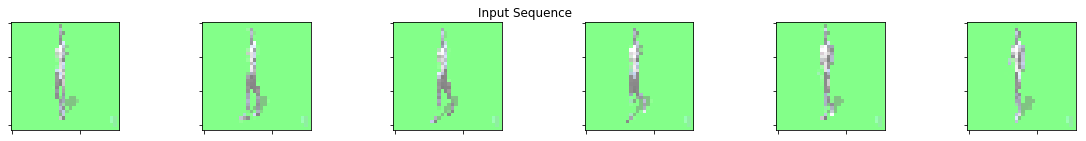

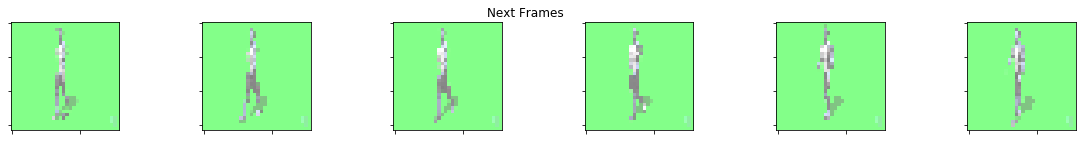

In [7]:
def show_sample_train(batch_size, gap, seq_size):
    seq_input, seq_gd = sample_train(batch_size=batch_size, gap=gap, seq_size= seq_size)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(seq_input), np.max(seq_input)))
    print("seq_input shape:            {}".format(seq_input.shape))
    print("seq_gd    shape:            {}".format(seq_gd.shape))
    selected = np.random.choice(range(batch_size))
    size = (20, 2)
    plot_images_ndarray(seq_input[selected], title="Input Sequence", size = size)
    plot_images_ndarray(seq_gd[selected], title="Next Frames", size = size)
    
show_sample_train(batch_size = 4, gap = 7, seq_size=6)

### Sample of Test Data

Range of Image Piece Value: [0.0, 1.0]
seq_input shape:            (2, 5, 32, 32, 3)
seq_gd    shape:            (2, 5, 32, 32, 3)


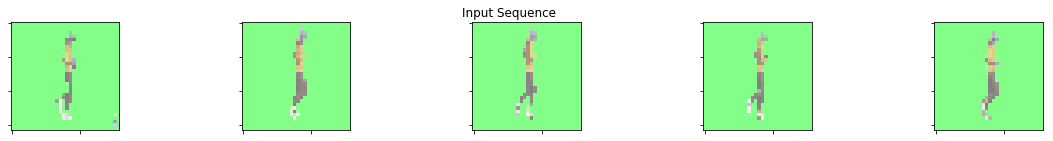

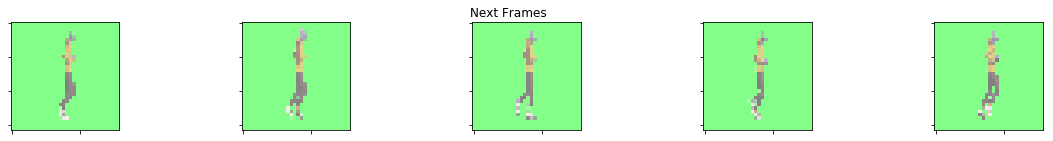

In [8]:
def show_sample_test(batch_size, gap, seq_size):
    seq_input, seq_gd = sample_test(batch_size=batch_size, gap=gap, seq_size= seq_size)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(seq_input), np.max(seq_input)))
    print("seq_input shape:            {}".format(seq_input.shape))
    print("seq_gd    shape:            {}".format(seq_gd.shape))
    selected = np.random.choice(range(batch_size))
    size = (20, 2)
    plot_images_ndarray(seq_input[selected], title="Input Sequence", size = size)
    plot_images_ndarray(seq_gd[selected], title="Next Frames", size = size)
    
show_sample_test(batch_size = 2, gap = 5, seq_size=5)

# Param

In [58]:
seq_size         = 9 #9
feature_size     = 1024*4    # size of feature vector for LSTM
lstm_state_size  = feature_size   # size of hidden state: [lstm_state_size, lstm_state_size]

num_iteration    = 1000 #4000
gap              = 1
batch_size       = 4
learning_rate    = 1.6e-4
beta             = 0.9

assert feature_size%64 == 0, "feature_size must be divisable by 64!"
feature_channels = int(feature_size/8/8)

model_save_path = "trained_model/LSTM_box_32x32/{}/".format(time())

## Create Directory for Model to be saved

In [59]:
try:
    os.mkdir(model_save_path)
    print("Model to be saved at {}".format(model_save_path))
except:
    assert "Cannot create save folder!"

# Encoder

In [60]:
def encode_img(img, is_training=True):
    """
    Input:
        batch size of img
    Output:
        batch size of feature [batch_size, feature_size]
    """
    x = img
    x = tf.reshape(img, [-1, 32, 32, 3])
    
    x = tf.layers.conv2d(x, filters = 32, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 32, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = feature_channels, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.contrib.layers.flatten(x)
    return x

In [61]:
def encode_seq(img_seq, seq_size = seq_size):
    """
    Input:
        img_seq: sequence of images      Tensor         [batch_size, seq_size, 32, 32]
    Output:
        encoded feature of the sequence  List of Tensor [batch_size, feature_size] of length seq_size
    """
    img_seq = tf.transpose(img_seq, perm=[1, 0, 2, 3, 4]) # [seq_size, batch_size, 32, 32, 3]
    
    return [encode_img(img_seq[i]) for i in range(seq_size)]

# Decoder

In [88]:
def decode(feature, is_training=True):
    """
    Input:
        batch size of feature [batch_size, 8, 8, feature_channel]
    Output:
        batch size of img [batch_size, 32, 32, 1]
    """
    x = tf.reshape(feature, [-1, 8, 8, feature_channels])
    x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=3,  strides=2, activation=tf.nn.tanh, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    img = tf.layers.conv2d_transpose(x, filters=3, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    return img

## Loss

In [89]:
def get_loss(gd_imgs, output_imgs):
    """
    Input:
        gd_imgs, output_imgs: [batch_size, seq_size, 8, 8, 1]
    Output:
        scaler loss
    """
    #gd_imgs, output_imgs = tf.contrib.layers.flatten(gd_imgs), tf.contrib.layers.flatten(output_imgs)
    return tf.norm(gd_imgs - output_imgs)

In [90]:
def scale_loss(loss, seq_size = seq_size, batch_size = batch_size):
    return loss/seq_size/batch_size/2*255

### Solver

In [91]:
def get_solver(beta1=0.5, learning_rate=1e-3): #learning_rate=1e-3, 
    #global_step = tf.Variable(0, trainable=False)
    #learning_rate = tf.train.exponential_decay(1e-4, global_step, 100, 0.96, staircase=False)

    return tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(loss)

## Computation Graph

In [92]:
tf.reset_default_graph()

batch_seq        = tf.placeholder(tf.float32, [None, seq_size, 32, 32, 3], name = "batch_seq")
batch_next       = tf.placeholder(tf.float32, [None, seq_size, 32, 32, 3], name = "batch_next")
is_training      = tf.placeholder(tf.bool, (), name = "is_training")

feature_seq      = encode_seq(batch_seq)

lstm_cell1       = rnn.BasicLSTMCell(lstm_state_size)
# lstm_cell2       = rnn.BasicLSTMCell(lstm_state_size)
# Cell             = rnn.MultiRNNCell([lstm_cell1, lstm_cell2])
Cell = lstm_cell1
output_feature, states = rnn.static_rnn(Cell, feature_seq, dtype=tf.float32)

output_imgs = tf.stack([decode(f) for f in output_feature], axis=1)  # [seq_size, batch_size, 32, 32, 1]

loss = get_loss(batch_next, output_imgs)


#solver = get_solver(learning_rate, beta)

train_step = get_solver(beta) #learning_rate, #solver.minimize(loss)

# add to saver
tf.add_to_collection('output_batch_img', output_imgs)
tf.add_to_collection('loss', loss)

In [93]:
def train(sess, train_step, loss, batch_size, num_iteration, \
          plot_every = 400, show_loss_every=400, num_plot = 6,  save_every = 1000):
    losses = []
    learning_rate_cache = []
    saver = tf.train.Saver()
    for i in range(1, num_iteration+1):
        # get a sample
        gap = 1 #np.random.choice([1,3,5,7,9])
        seq_input, seq_gd = sample_train(batch_size, gap, seq_size = seq_size)
        dic = {batch_seq: seq_input, batch_next: seq_gd, is_training: True}
        #tf.train.exponential_decay(1.6e-3, 100, 10000, 0.96)
        sess.run([train_step], dic)
        curr_loss = sess.run(loss, dic)
        curr_loss = scale_loss(curr_loss)# tweek loss to match report loss
        
        losses.append(curr_loss)
        learning_rate_cache.append(learning_rate)
    
        if i%show_loss_every ==0:
            print("Iteration {}:  loss = {} | Gap = {} | Learning Rate={}".format(i, curr_loss, gap, learning_rate))
            
        if i%plot_every == 0:
            seq_input, seq_gd = sample_train(1, gap, seq_size = seq_size)
            seq_generated = sess.run(output_imgs, feed_dict=\
                                      {batch_seq: seq_input, batch_next: seq_gd, is_training: False})
            seq_generated = seq_generated[0]
            plot_batch_images(seq_generated[:num_plot], (16, 2) , "Iteration: {} | gap = {}".format(i + plot_every, gap))
            
        #if i%save_every == 0:
        #    saver.save(sess, model_save_path, global_step = i)   
    #save_learning_curve(iterations = list(range(1, num_iteration+1)), loss = losses, \
     #                       save_path = "output/learning_curve/box_LSTM-64x64-{}".format(time()))
    return losses, learning_rate_cache

In [94]:
#save_learning_curve

# Train

Iteration 1:  loss = 660.6090291341146 | Gap = 1 | Learning Rate=0.00016


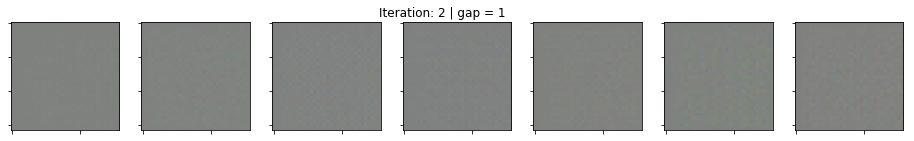

Iteration 2:  loss = 608.3061091105144 | Gap = 1 | Learning Rate=0.00016


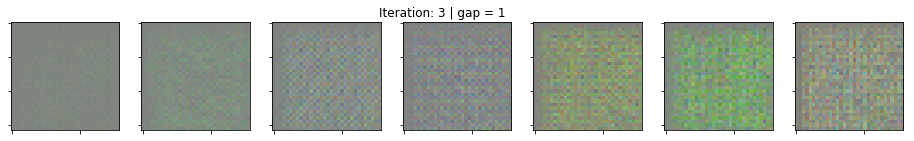

Iteration 3:  loss = 553.4570217132568 | Gap = 1 | Learning Rate=0.00016


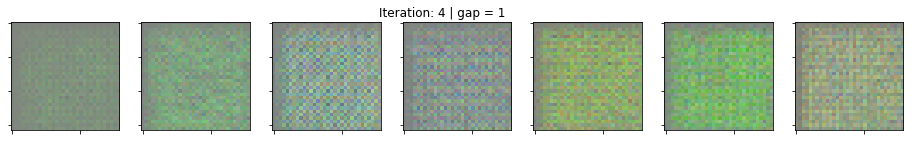

Iteration 4:  loss = 441.9160032272339 | Gap = 1 | Learning Rate=0.00016


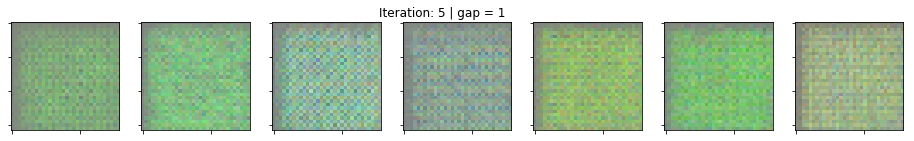

Iteration 5:  loss = 431.09896659851074 | Gap = 1 | Learning Rate=0.00016


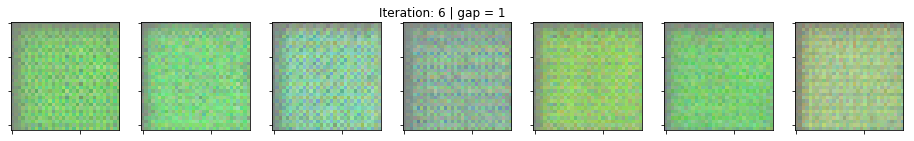

Iteration 6:  loss = 374.44351355234784 | Gap = 1 | Learning Rate=0.00016


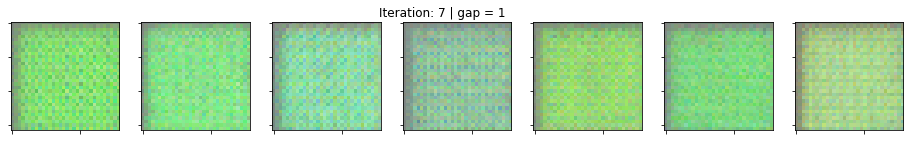

Iteration 7:  loss = 332.16094970703125 | Gap = 1 | Learning Rate=0.00016


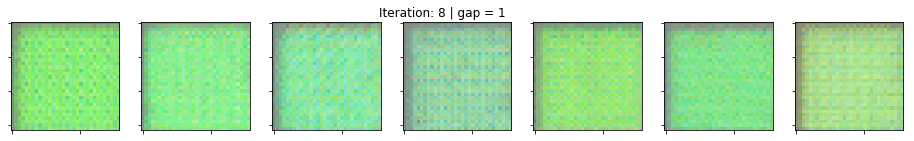

Iteration 8:  loss = 299.7206211090088 | Gap = 1 | Learning Rate=0.00016


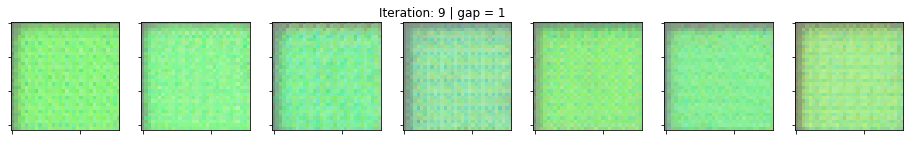

Iteration 9:  loss = 268.9130767186483 | Gap = 1 | Learning Rate=0.00016


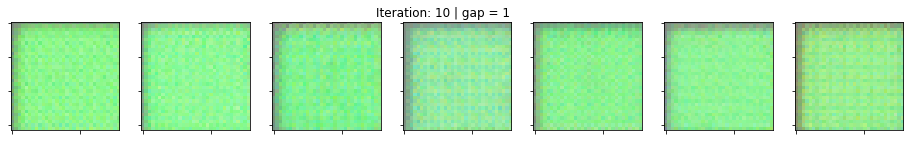

Iteration 10:  loss = 250.03496011098227 | Gap = 1 | Learning Rate=0.00016


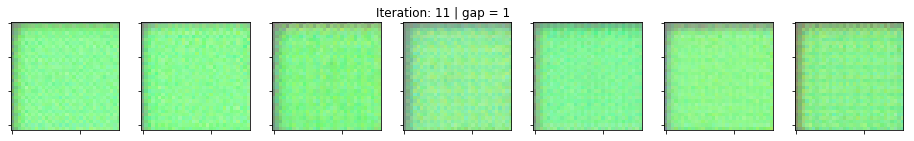

Iteration 11:  loss = 237.1431064605713 | Gap = 1 | Learning Rate=0.00016


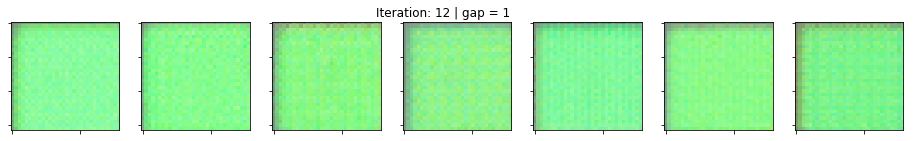

Iteration 12:  loss = 230.50920963287354 | Gap = 1 | Learning Rate=0.00016


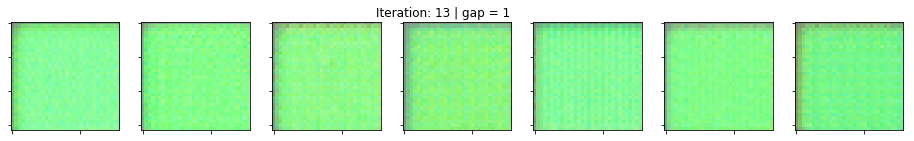

Iteration 13:  loss = 219.3657350540161 | Gap = 1 | Learning Rate=0.00016


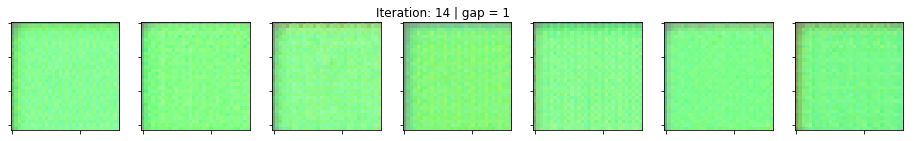

Iteration 14:  loss = 202.6279878616333 | Gap = 1 | Learning Rate=0.00016


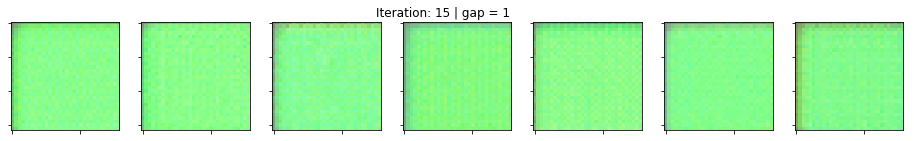

Iteration 15:  loss = 200.1679762204488 | Gap = 1 | Learning Rate=0.00016


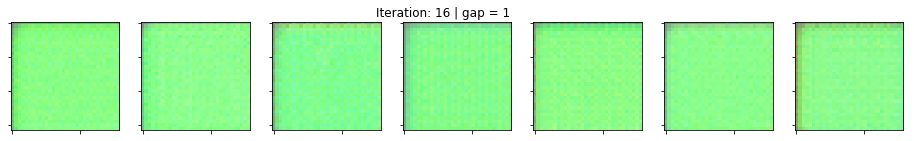

Iteration 16:  loss = 195.30704736709595 | Gap = 1 | Learning Rate=0.00016


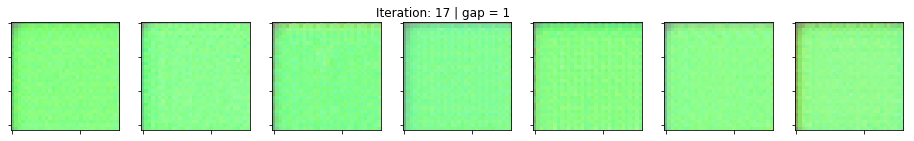

Iteration 17:  loss = 200.30493100484213 | Gap = 1 | Learning Rate=0.00016


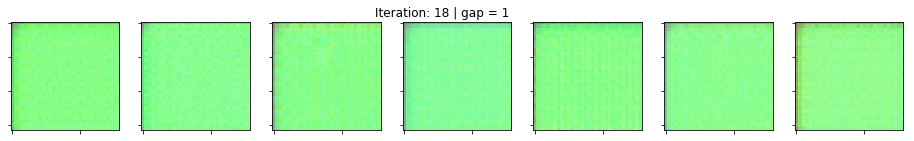

Iteration 18:  loss = 209.5637067159017 | Gap = 1 | Learning Rate=0.00016


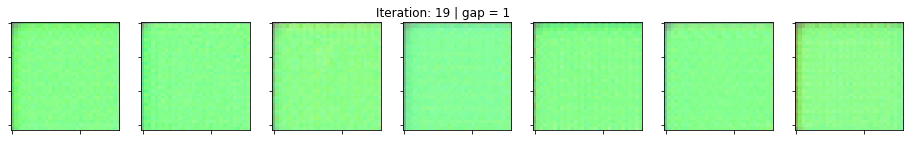

Iteration 19:  loss = 189.39614534378052 | Gap = 1 | Learning Rate=0.00016


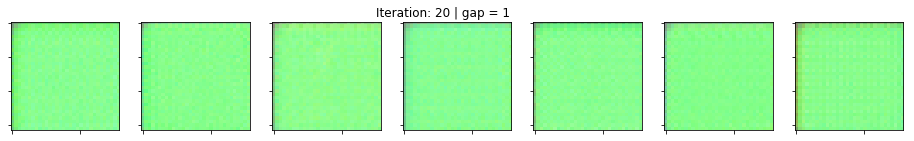

Iteration 20:  loss = 188.2498025894165 | Gap = 1 | Learning Rate=0.00016


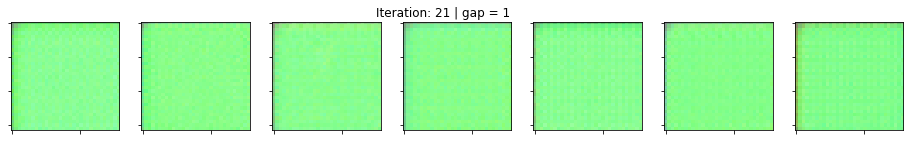

Iteration 21:  loss = 167.6952362060547 | Gap = 1 | Learning Rate=0.00016


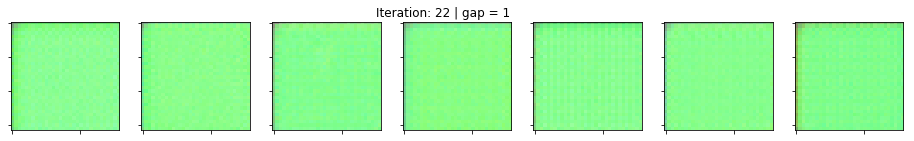

Iteration 22:  loss = 182.20855236053467 | Gap = 1 | Learning Rate=0.00016


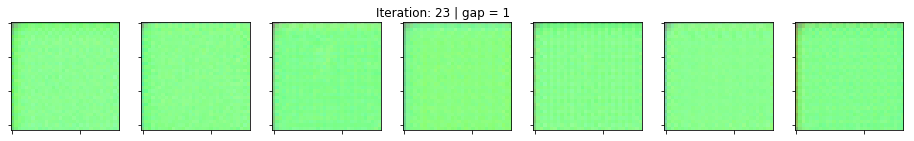

Iteration 23:  loss = 162.27285623550415 | Gap = 1 | Learning Rate=0.00016


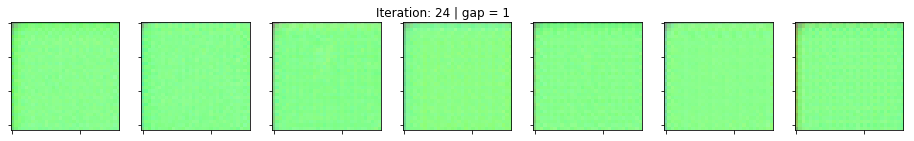

Iteration 24:  loss = 190.37826935450235 | Gap = 1 | Learning Rate=0.00016


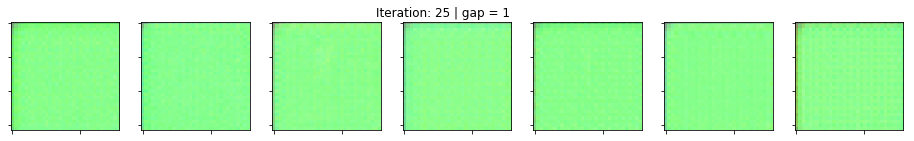

Iteration 25:  loss = 165.41926304499307 | Gap = 1 | Learning Rate=0.00016


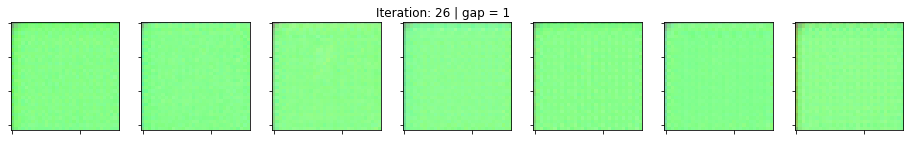

Iteration 26:  loss = 356.6655747095744 | Gap = 1 | Learning Rate=0.00016


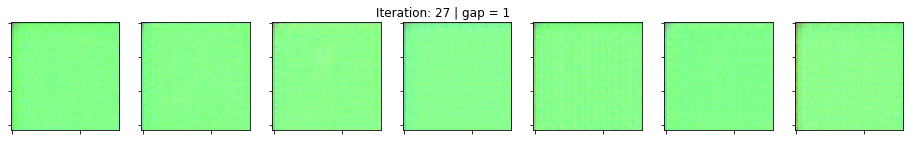

Iteration 27:  loss = 371.8838628133138 | Gap = 1 | Learning Rate=0.00016


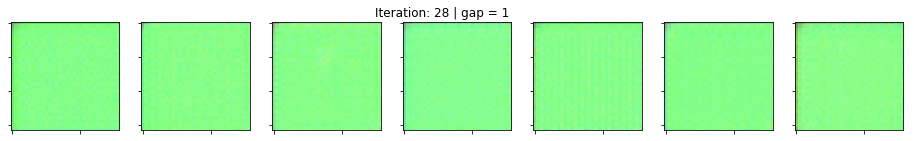

Iteration 28:  loss = 167.24203030268353 | Gap = 1 | Learning Rate=0.00016


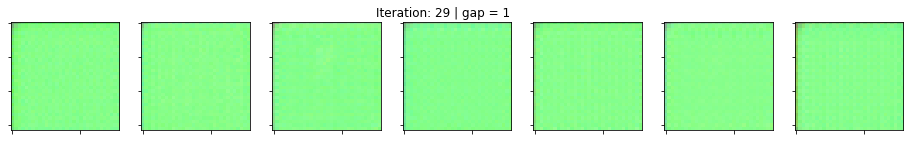

Iteration 29:  loss = 166.06538375218707 | Gap = 1 | Learning Rate=0.00016


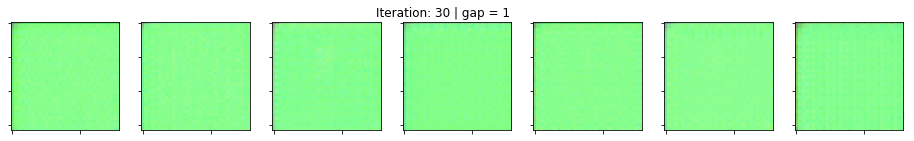

Iteration 30:  loss = 162.38085826237995 | Gap = 1 | Learning Rate=0.00016


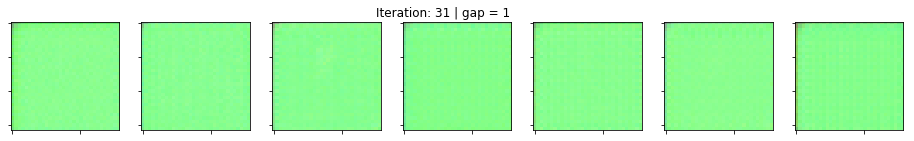

Iteration 31:  loss = 153.71070305506387 | Gap = 1 | Learning Rate=0.00016


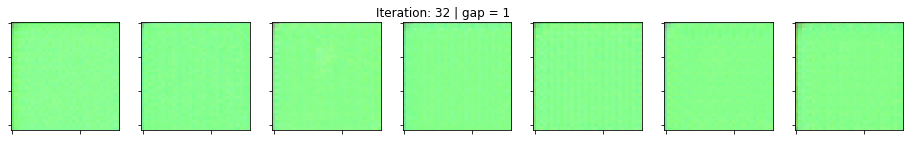

Iteration 32:  loss = 155.01617113749188 | Gap = 1 | Learning Rate=0.00016


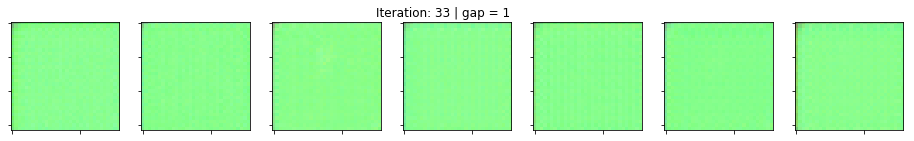

Iteration 33:  loss = 159.64011430740356 | Gap = 1 | Learning Rate=0.00016


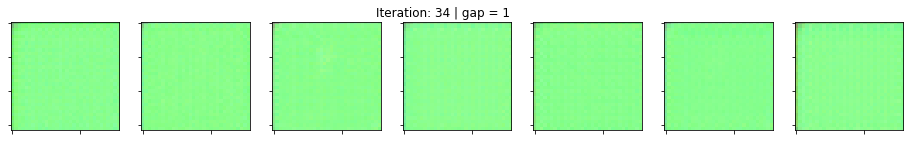

Iteration 34:  loss = 148.55892260869345 | Gap = 1 | Learning Rate=0.00016


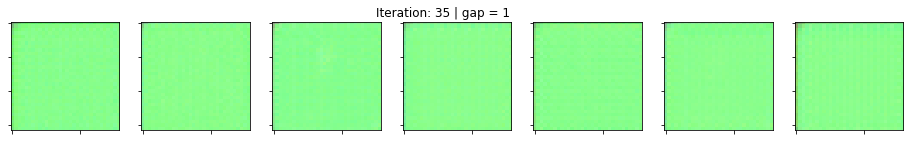

Iteration 35:  loss = 161.287895043691 | Gap = 1 | Learning Rate=0.00016


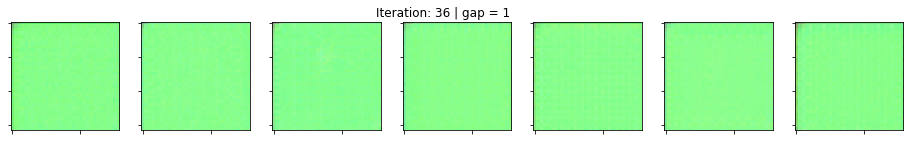

Iteration 36:  loss = 180.153595606486 | Gap = 1 | Learning Rate=0.00016


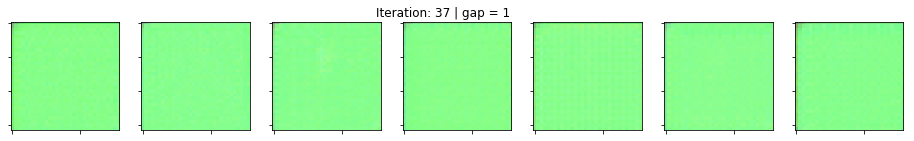

Iteration 37:  loss = 166.51676575342813 | Gap = 1 | Learning Rate=0.00016


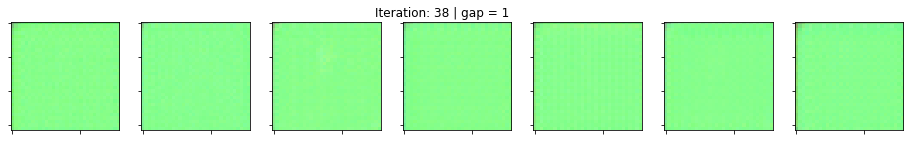

Iteration 38:  loss = 167.95504093170166 | Gap = 1 | Learning Rate=0.00016


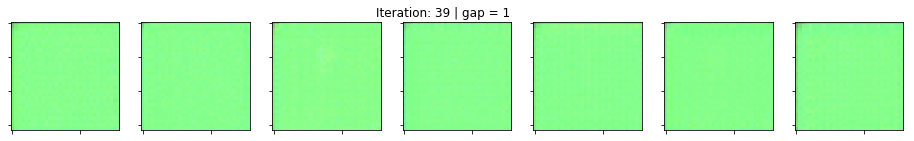

Iteration 39:  loss = 149.67323223749798 | Gap = 1 | Learning Rate=0.00016


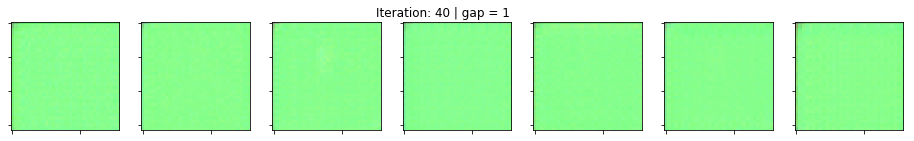

Iteration 40:  loss = 154.7739839553833 | Gap = 1 | Learning Rate=0.00016


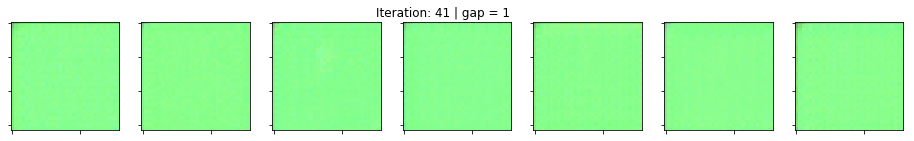

Iteration 41:  loss = 171.4046343167623 | Gap = 1 | Learning Rate=0.00016


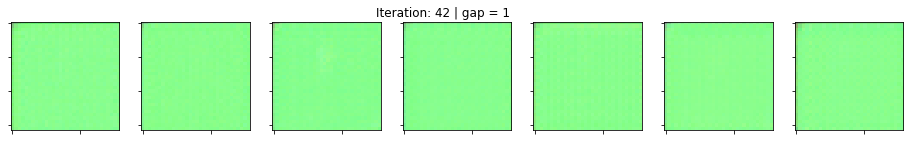

Iteration 42:  loss = 151.41039768854776 | Gap = 1 | Learning Rate=0.00016


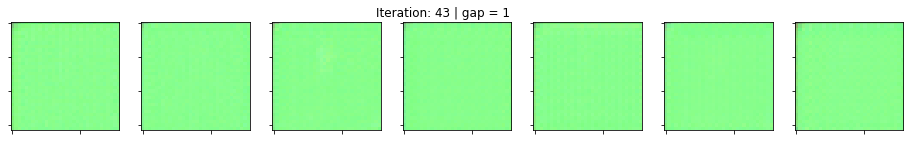

Iteration 43:  loss = 161.3727267583211 | Gap = 1 | Learning Rate=0.00016


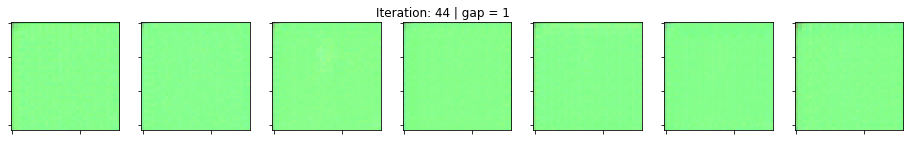

Iteration 44:  loss = 150.89913765589398 | Gap = 1 | Learning Rate=0.00016


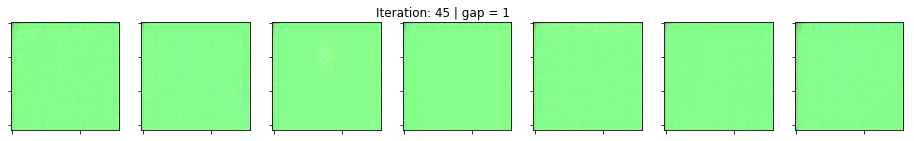

Iteration 45:  loss = 162.47668743133545 | Gap = 1 | Learning Rate=0.00016


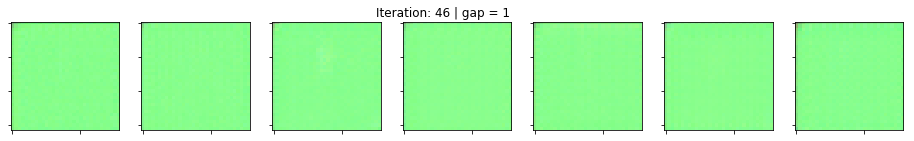

Iteration 46:  loss = 166.00372234980267 | Gap = 1 | Learning Rate=0.00016


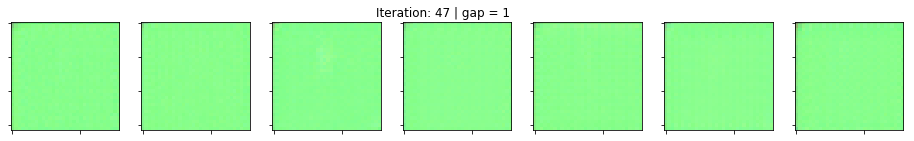

Iteration 47:  loss = 169.5451052983602 | Gap = 1 | Learning Rate=0.00016


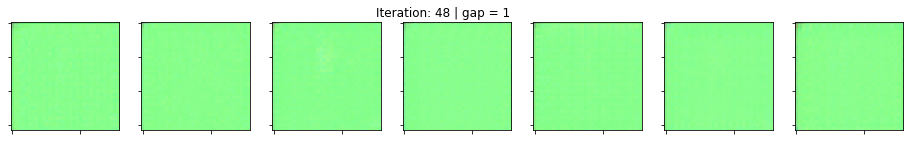

Iteration 48:  loss = 190.58432976404828 | Gap = 1 | Learning Rate=0.00016


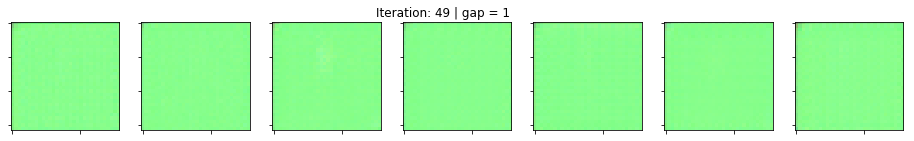

Iteration 49:  loss = 150.9475859006246 | Gap = 1 | Learning Rate=0.00016


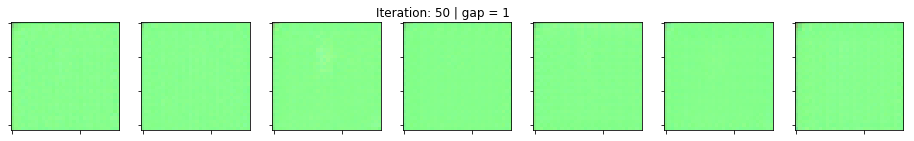

Iteration 50:  loss = 153.3627700805664 | Gap = 1 | Learning Rate=0.00016


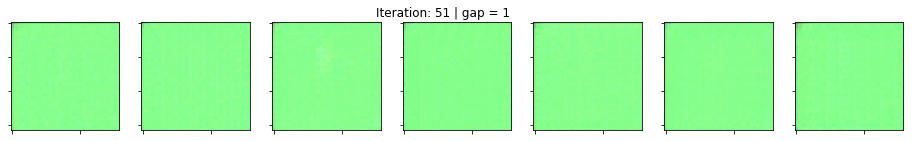

Iteration 51:  loss = 162.0230221748352 | Gap = 1 | Learning Rate=0.00016


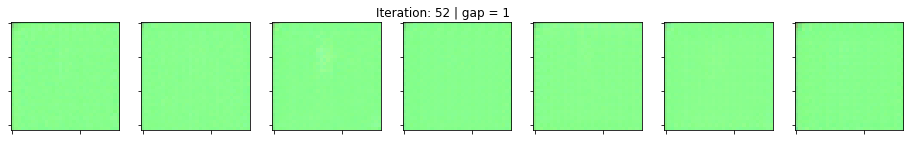

Iteration 52:  loss = 148.888103167216 | Gap = 1 | Learning Rate=0.00016


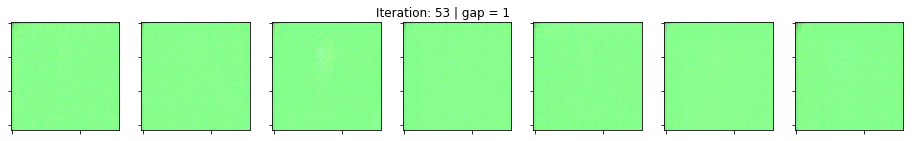

Iteration 53:  loss = 167.27707624435425 | Gap = 1 | Learning Rate=0.00016


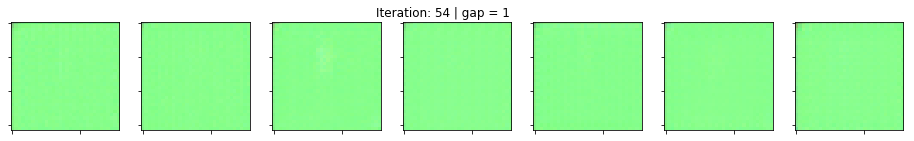

Iteration 54:  loss = 158.88651847839355 | Gap = 1 | Learning Rate=0.00016


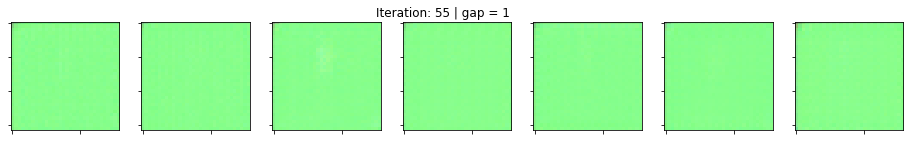

Iteration 55:  loss = 155.73170820871988 | Gap = 1 | Learning Rate=0.00016


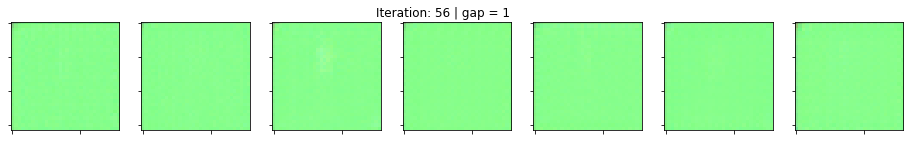

Iteration 56:  loss = 158.64293972651166 | Gap = 1 | Learning Rate=0.00016


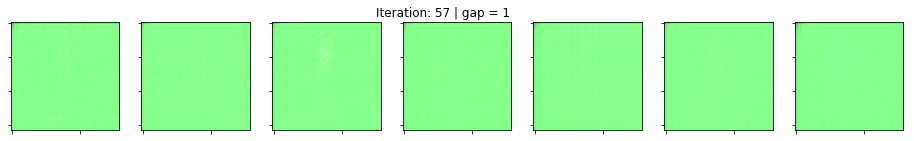

Iteration 57:  loss = 148.0636183420817 | Gap = 1 | Learning Rate=0.00016


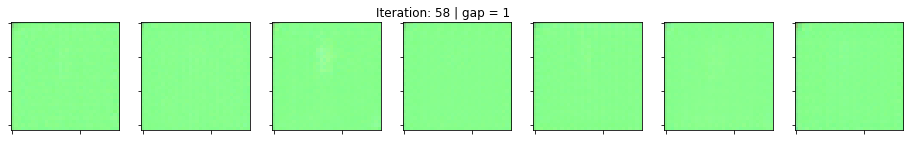

Iteration 58:  loss = 329.3899154663086 | Gap = 1 | Learning Rate=0.00016


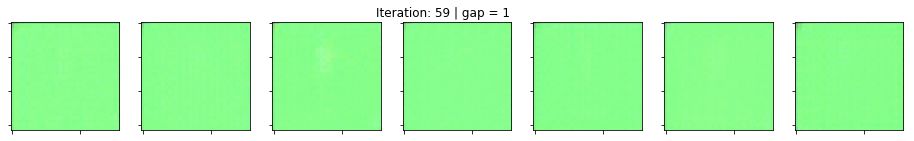

Iteration 59:  loss = 156.57231092453003 | Gap = 1 | Learning Rate=0.00016


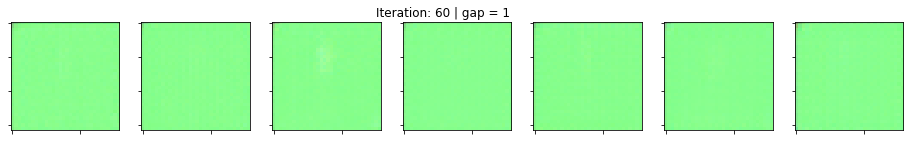

Iteration 60:  loss = 144.73902304967245 | Gap = 1 | Learning Rate=0.00016


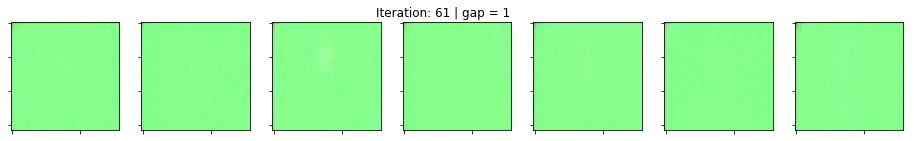

Iteration 61:  loss = 141.15989208221436 | Gap = 1 | Learning Rate=0.00016


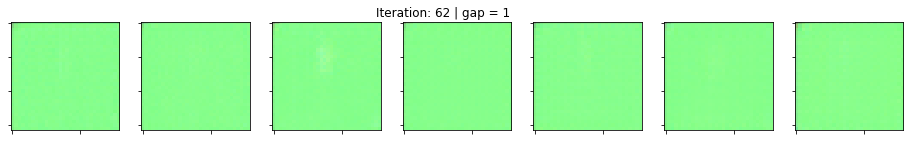

Iteration 62:  loss = 139.29882287979126 | Gap = 1 | Learning Rate=0.00016


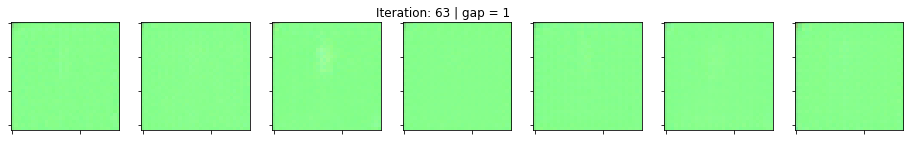

Iteration 63:  loss = 132.70948330561322 | Gap = 1 | Learning Rate=0.00016


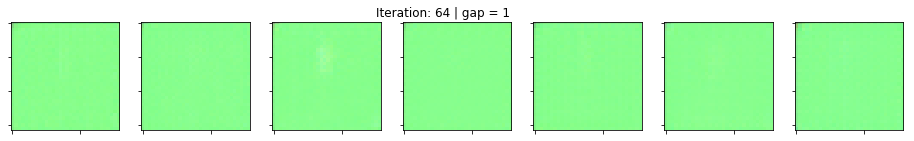

Iteration 64:  loss = 135.4321233431498 | Gap = 1 | Learning Rate=0.00016


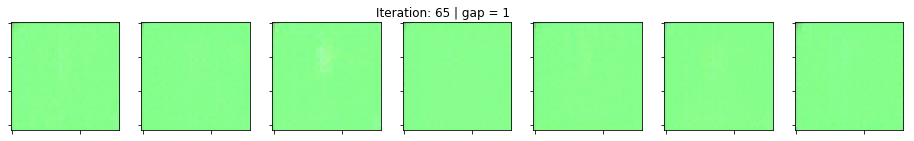

Iteration 65:  loss = 158.59078963597614 | Gap = 1 | Learning Rate=0.00016


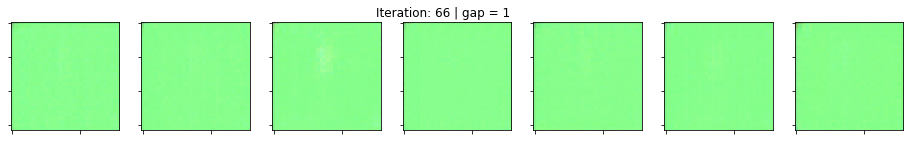

Iteration 66:  loss = 156.31738344828287 | Gap = 1 | Learning Rate=0.00016


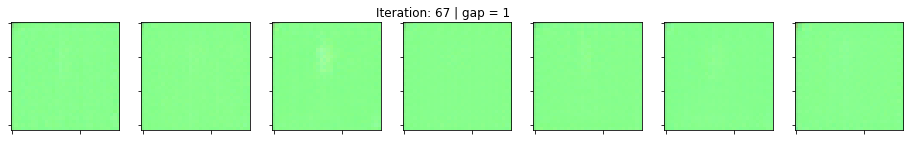

Iteration 67:  loss = 152.78899749120077 | Gap = 1 | Learning Rate=0.00016


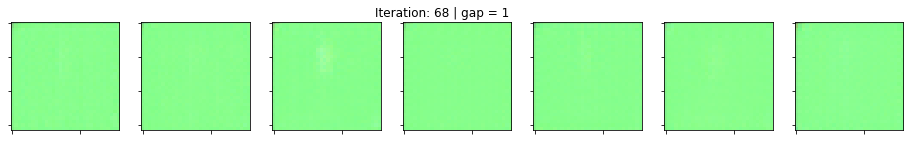

Iteration 68:  loss = 137.9555662473043 | Gap = 1 | Learning Rate=0.00016


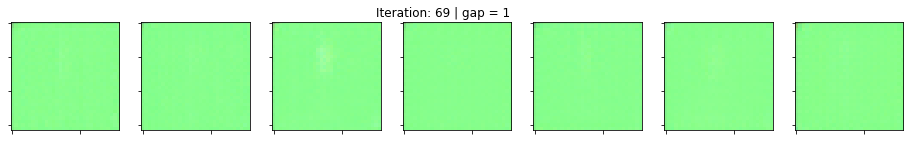

Iteration 69:  loss = 163.0736978848775 | Gap = 1 | Learning Rate=0.00016


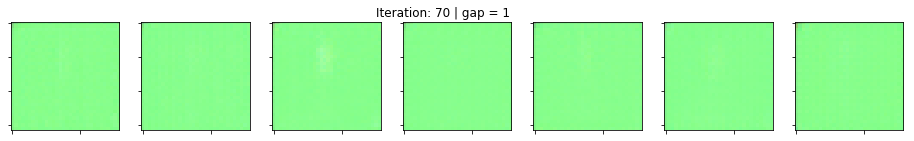

Iteration 70:  loss = 161.31117343902588 | Gap = 1 | Learning Rate=0.00016


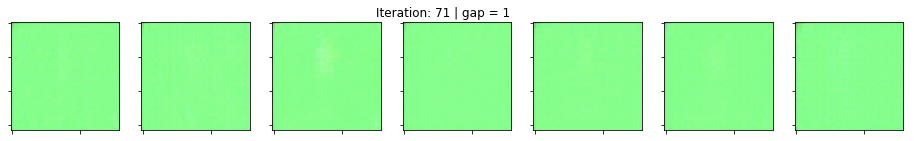

Iteration 71:  loss = 132.36807584762573 | Gap = 1 | Learning Rate=0.00016


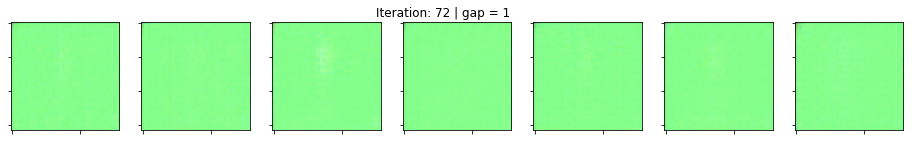

Iteration 72:  loss = 143.1808837254842 | Gap = 1 | Learning Rate=0.00016


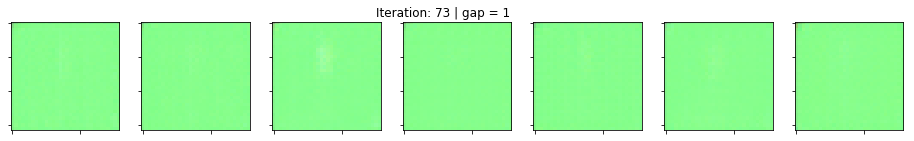

Iteration 73:  loss = 159.18205817540488 | Gap = 1 | Learning Rate=0.00016


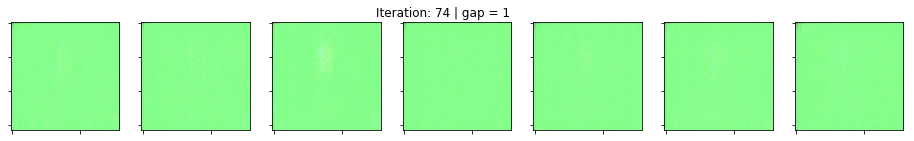

Iteration 74:  loss = 143.06992292404175 | Gap = 1 | Learning Rate=0.00016


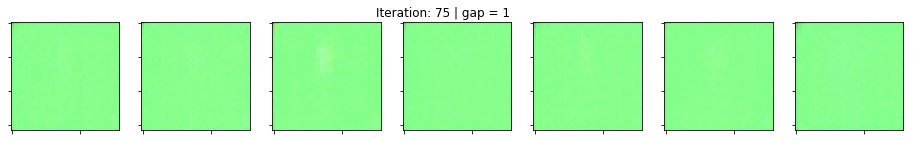

Iteration 75:  loss = 140.53318579991657 | Gap = 1 | Learning Rate=0.00016


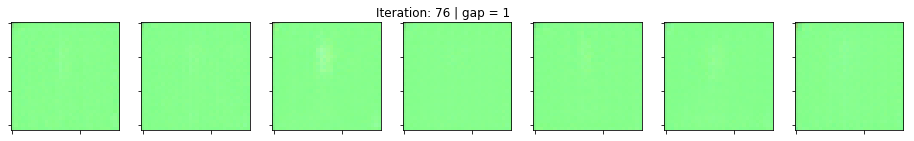

Iteration 76:  loss = 151.58653259277344 | Gap = 1 | Learning Rate=0.00016


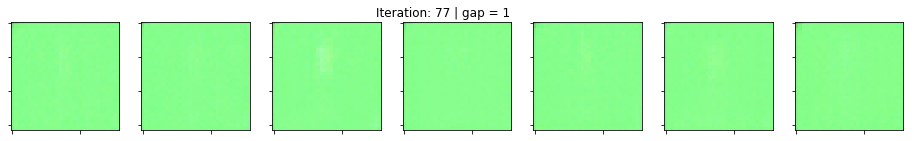

Iteration 77:  loss = 142.7344330151876 | Gap = 1 | Learning Rate=0.00016


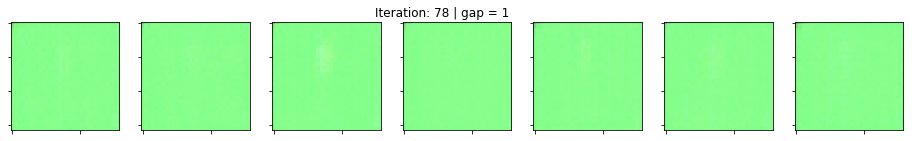

Iteration 78:  loss = 137.41096258163452 | Gap = 1 | Learning Rate=0.00016


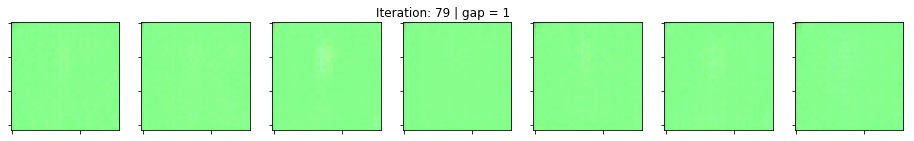

Iteration 79:  loss = 138.980450630188 | Gap = 1 | Learning Rate=0.00016


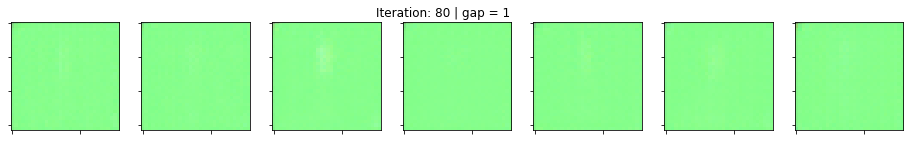

Iteration 80:  loss = 151.79270108540854 | Gap = 1 | Learning Rate=0.00016


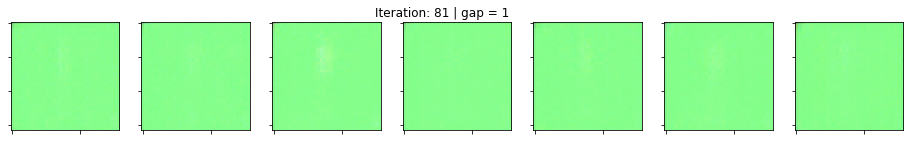

Iteration 81:  loss = 154.4745667775472 | Gap = 1 | Learning Rate=0.00016


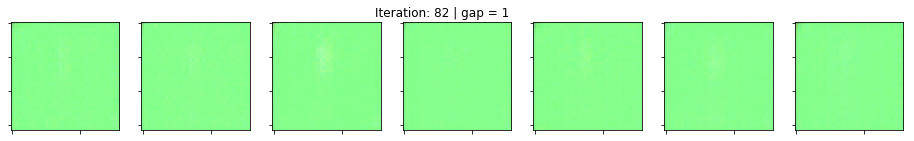

Iteration 82:  loss = 143.17692518234253 | Gap = 1 | Learning Rate=0.00016


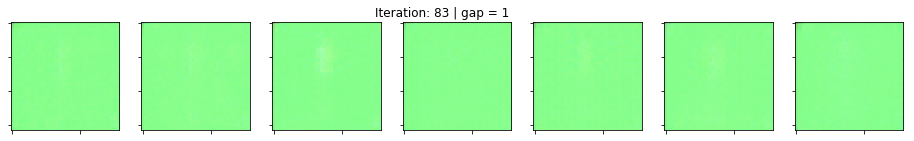

Iteration 83:  loss = 157.9369815190633 | Gap = 1 | Learning Rate=0.00016


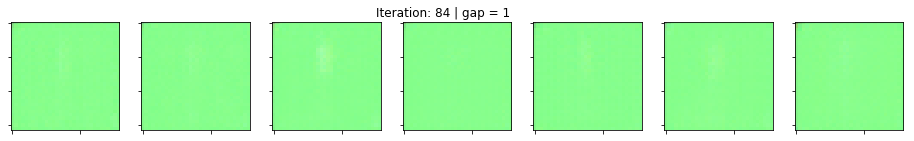

Iteration 84:  loss = 338.95713329315186 | Gap = 1 | Learning Rate=0.00016


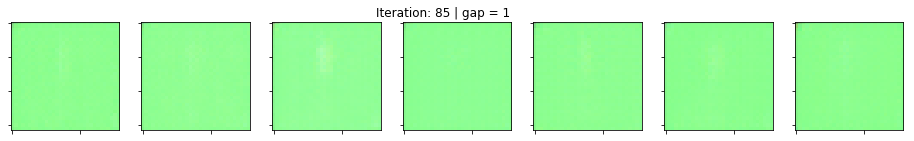

Iteration 85:  loss = 145.77041943868002 | Gap = 1 | Learning Rate=0.00016


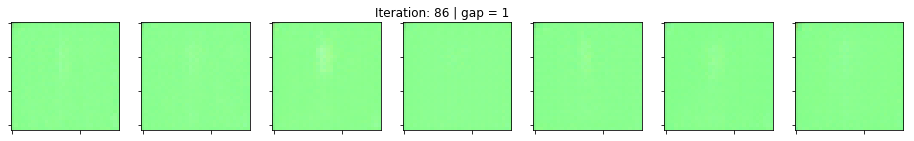

Iteration 86:  loss = 167.87986914316812 | Gap = 1 | Learning Rate=0.00016


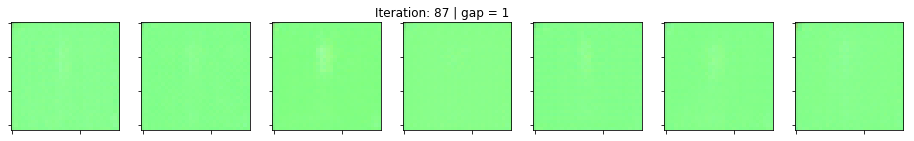

Iteration 87:  loss = 161.9422976175944 | Gap = 1 | Learning Rate=0.00016


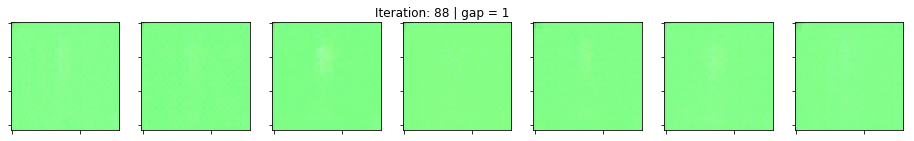

Iteration 88:  loss = 333.17866007486975 | Gap = 1 | Learning Rate=0.00016


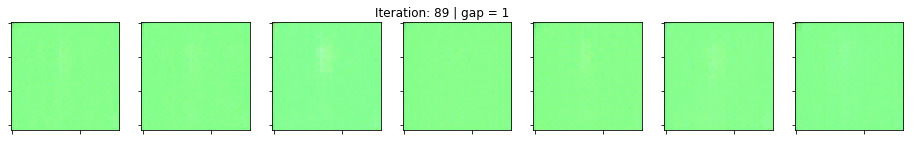

Iteration 89:  loss = 153.90661716461182 | Gap = 1 | Learning Rate=0.00016


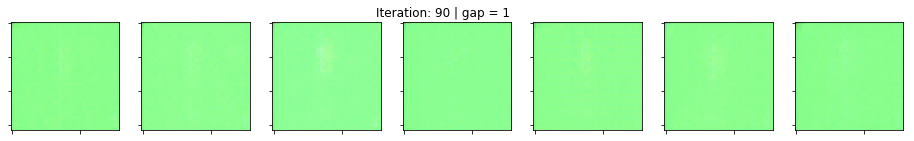

Iteration 90:  loss = 141.15192095438638 | Gap = 1 | Learning Rate=0.00016


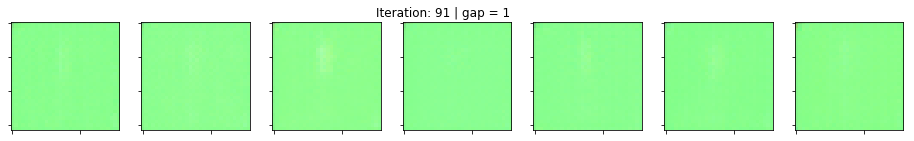

Iteration 91:  loss = 160.33206224441528 | Gap = 1 | Learning Rate=0.00016


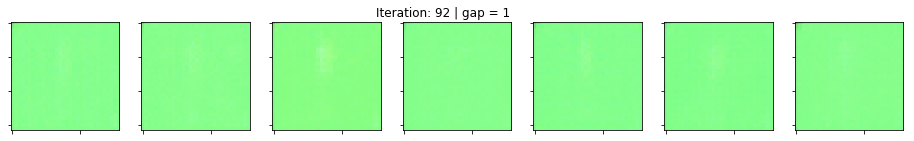

Iteration 92:  loss = 146.9107230504354 | Gap = 1 | Learning Rate=0.00016


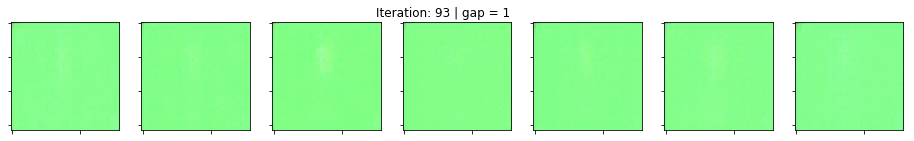

Iteration 93:  loss = 150.2068249384562 | Gap = 1 | Learning Rate=0.00016


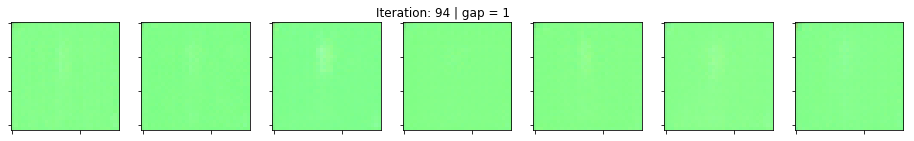

Iteration 94:  loss = 146.67647997538248 | Gap = 1 | Learning Rate=0.00016


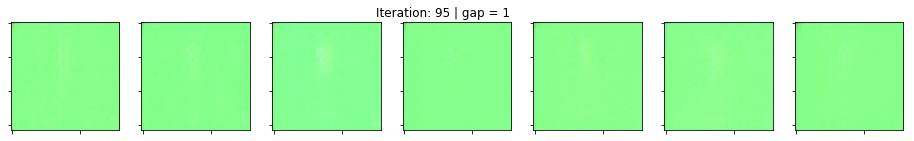

Iteration 95:  loss = 148.48850647608438 | Gap = 1 | Learning Rate=0.00016


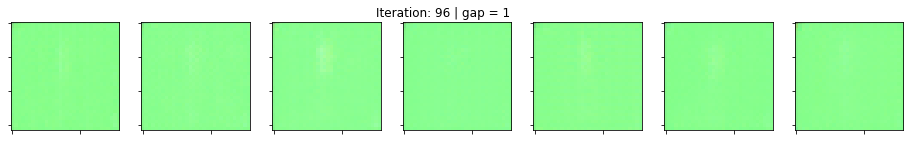

Iteration 96:  loss = 157.45383659998575 | Gap = 1 | Learning Rate=0.00016


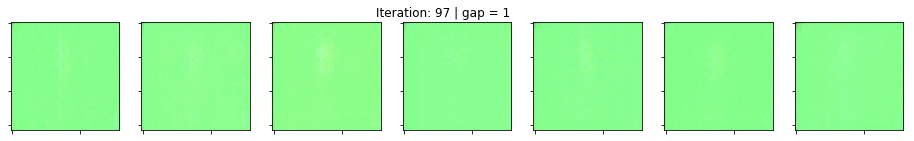

Iteration 97:  loss = 154.74886814753214 | Gap = 1 | Learning Rate=0.00016


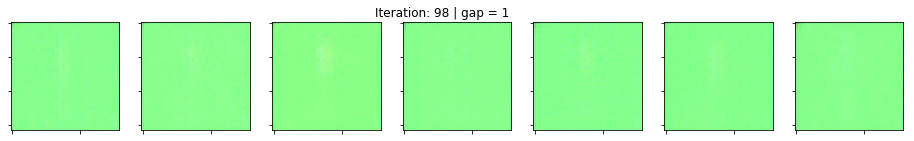

Iteration 98:  loss = 131.59613291422525 | Gap = 1 | Learning Rate=0.00016


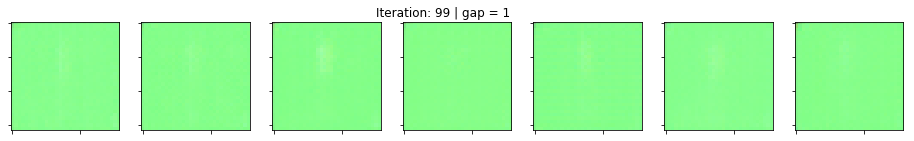

Iteration 99:  loss = 161.0894544919332 | Gap = 1 | Learning Rate=0.00016


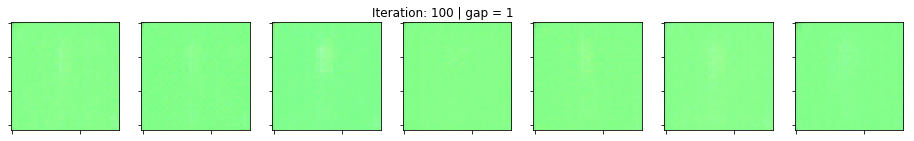

Iteration 100:  loss = 141.16974115371704 | Gap = 1 | Learning Rate=0.00016


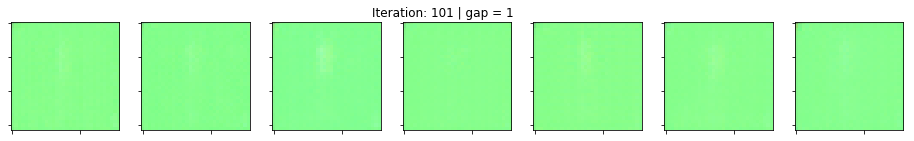

In [95]:
sess = get_session()
sess.run(tf.global_variables_initializer())
losses, learning_rate_cache = train(sess, train_step, loss, batch_size, num_iteration, \
               plot_every = 50, show_loss_every = 50, num_plot=7,  save_every = 7000)

## Plot Learning Curve

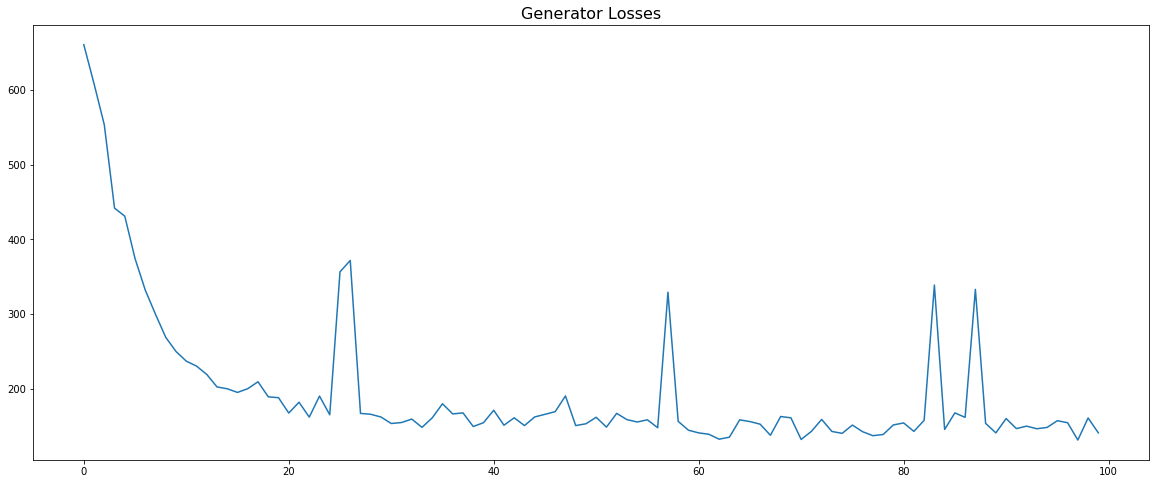

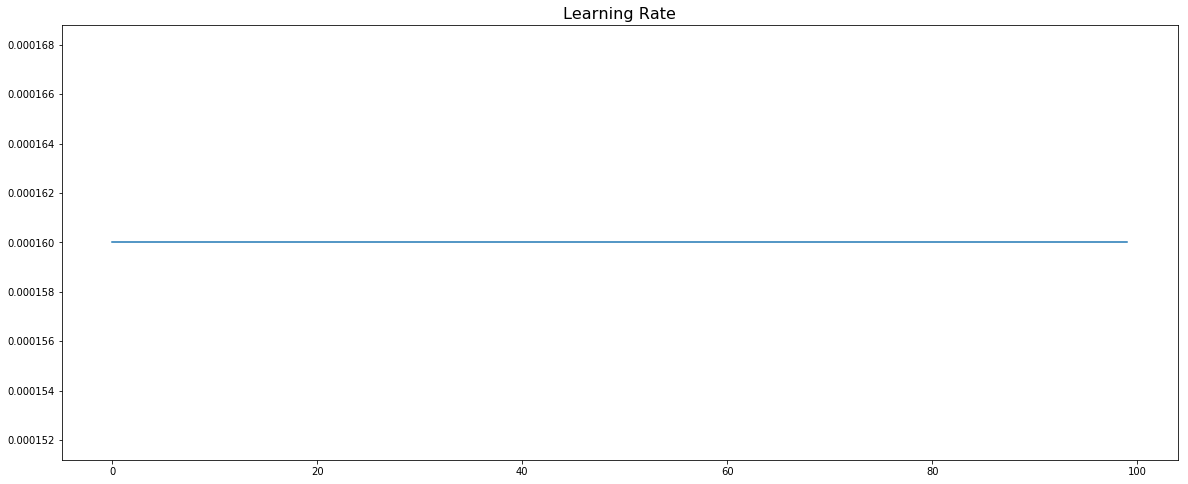

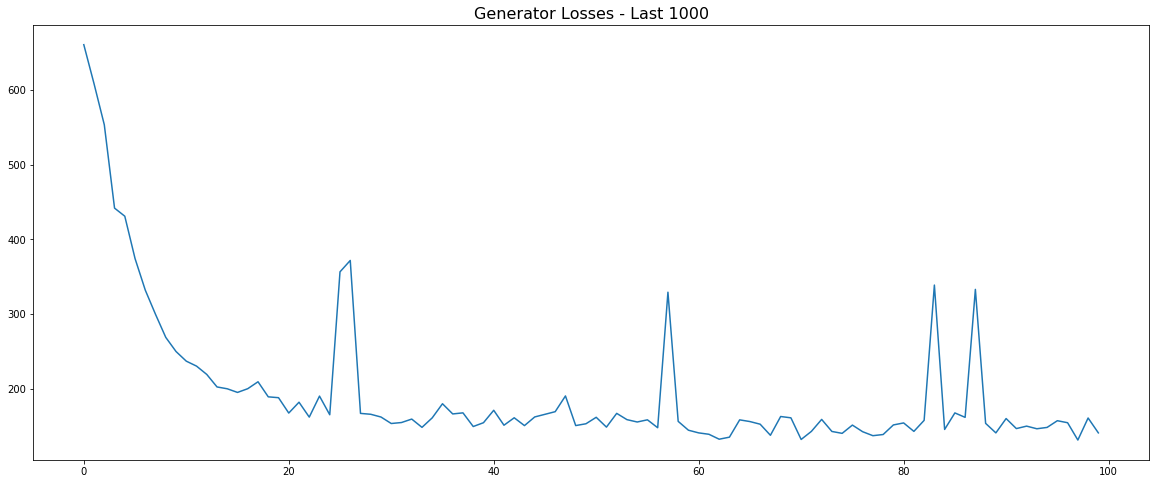

In [96]:
figsize = (20, 8)

plt.figure(figsize=figsize)
plt.plot(losses)
plt.title("Generator Losses", fontsize=16)
plt.show()

plt.figure(figsize=figsize)
plt.plot(learning_rate_cache)
plt.title("Learning Rate", fontsize=16)
plt.show()

plt.figure(figsize=figsize)
plt.plot(losses[-100:])
plt.title("Generator Losses - Last 1000", fontsize=16)
plt.show()

# Evaluate !

In [97]:
def report_loss(name, num_run = 100, gap = 3, batch_size = batch_size, seq_size = 3):
    losses = []
    for _ in range(num_run):
        if name == "train": seq_input, seq_gd = sample_train(1, gap, seq_size = seq_size)
        else:               seq_input, seq_gd = sample_test(1, gap, seq_size = seq_size)
        dic = {batch_seq: seq_input, batch_next: seq_gd, is_training: True}
        curr_loss = sess.run(loss, dic)
        losses.append(curr_loss)
    return scale_loss(np.mean(losses))

In [98]:
def get_generattion(seq_input):
    feed_dict={batch_seq: seq_input, is_training: False}
    gen_batch = sess.run(output_imgs, feed_dict)
    return gen_batch

In [99]:
def show_generations(name, seq_size = 6, gap = 3):
    if name == "train":  seq_input, seq_gd = sample_train(1, gap, seq_size = seq_size)
    else:                seq_input, seq_gd = sample_test(1, gap, seq_size = seq_size)
    
    seq_generated = get_generattion(seq_input)
    seq_generated, seq_input, seq_gd = seq_generated[0], seq_input[0], seq_gd[0]
    size = (20, 2)
    plot_images_ndarray(seq_input, title="Input Sequence", size = size)
    plot_images_ndarray(seq_gd, title="Next Frames - Ground Truth", size = size)
    plot_images_ndarray(seq_generated, title="Next Frames - Generated", size = size)

## - Evaluate on Training Data

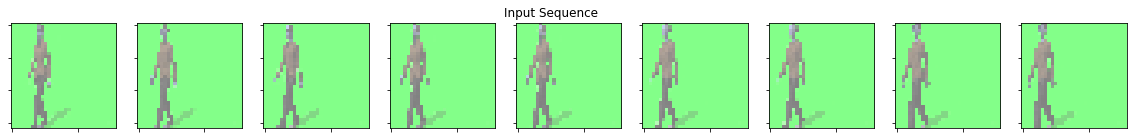

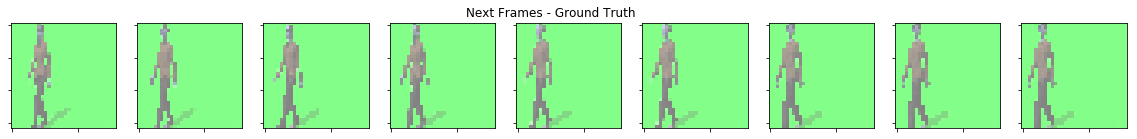

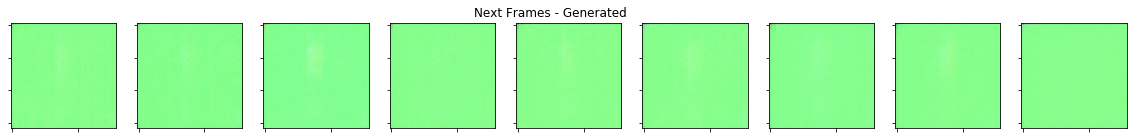

Training Loss = 74.91652329762776


In [100]:
def eval_train(seq_size = 3, gap = 3):
    show_generations("train", seq_size, gap)
    loss = report_loss("train", 100, gap, batch_size, seq_size = seq_size)
    print("Training Loss = {}".format(loss))
    return loss

train_loss = eval_train(seq_size = seq_size, gap = gap)

## - Evaluate on Test Data

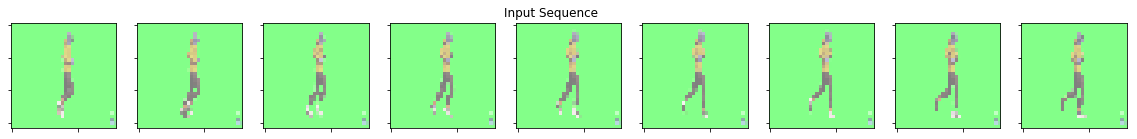

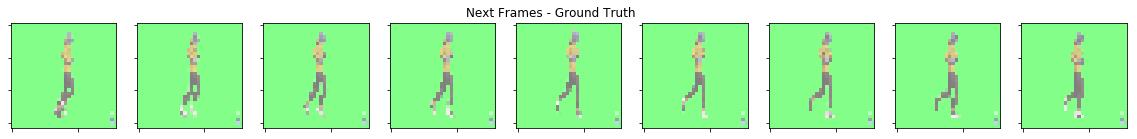

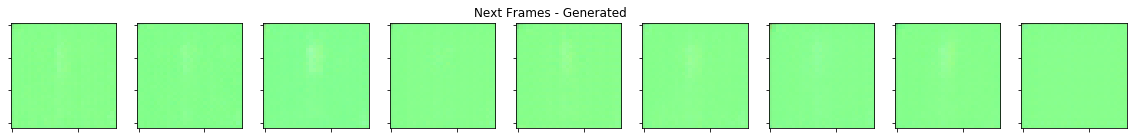

Test Loss = 80.22358536720276


In [102]:
def eval_test(seq_size = 3, gap = 3):
    show_generations("test", seq_size, gap)
    loss = report_loss("test", 100, gap, batch_size, seq_size = seq_size)
    print("Test Loss = {}".format(loss))
    return loss

test_loss = eval_test(seq_size = seq_size, gap = gap)